In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/synthbuster/standard"
suffix = "features/extraction_params/train_test/features_RGB.csv"
dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

In [4]:
datasets_train = {
    "dalle2": dalle2,
    "dalle3": dalle3,
    "firefly": firefly,
    "glide": glide,
    "midjourney": midjourney,
    "sd_1_3": sd_1_3,
    "sd_1_4": sd_1_4,
    "sd_2": sd_2,
    "sd_xl": sd_xl,
}

In [5]:
for dataset_name, dataset in datasets_train.items():
    datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])

## Data preparation

In [6]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [7]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [8]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}
X_test = {}

y_train = {}
y_val = {}
y_test = {}

Image_train = {}
Image_val = {}
Image_test = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    # get train, val and test sets
    X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    Image_test[key] = X_test[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)
    X_test[key] = X_test[key].drop('Image', axis=1)
    
# create dataset combining all train sets
X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

# create dataset combining all val sets
X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

# create dataset combining all test sets
X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

X_train['combined'] = X_train_all
y_train['combined'] = y_train_all

X_val['combined'] = X_val_all
y_val['combined'] = y_val_all

X_test['combined'] = X_test_all
y_test['combined'] = y_test_all

## Generalization

In [9]:
X_train_general = {}
y_train_general = {}
img_train_general = {}
for df_key, df in X_train.items():
    # for each dataset take all other datasets as train set except the current one
    X_train_general[df_key] = pd.concat([X_train[key] for key in X_train.keys() if key != 'combined' and key != df_key])
    y_train_general[df_key] = pd.concat([y_train[key] for key in X_train.keys() if key != 'combined' and key != df_key])
    img_train_general[df_key] = pd.concat([Image_train[key] for key in X_train.keys() if key != 'combined' and key != df_key])
    
X_train = X_train_general
y_train = y_train_general
Image_train = img_train_general

### Scale the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99990234375


Training set: dalle3

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.99970703125
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99970703125
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.999609375


Training set: firefly

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.99990234375
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99990234375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99990234375


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99990234375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99990234375


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99990234375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99990234375


Training set: sd_1_3

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9998046875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9998046875


Training set: sd_1_4

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9998046875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.999609375


Training set: sd_2

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99990234375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99990234375


Training set: sd_xl

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998046875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9998046875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99951171875


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998263888888889
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9998263888888889
Finished training RandomForestClassifier.
Training accuracy: 1.0
Finished training LinearSVC.
Training accuracy: 0.9995659722222222


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

### Validation data

In [13]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9531
F1: 0.9530
Precision: 0.9552
Recall: 0.9531
MCC: 0.9083

Model: LinearDiscriminantAnalysis
Accuracy: 0.8969
F1: 0.8967
Precision: 0.9016
Recall: 0.8969
MCC: 0.7986

Model: RandomForestClassifier
Accuracy: 0.8906
F1: 0.8891
Precision: 0.9100
Recall: 0.8906
MCC: 0.7998

Model: LinearSVC
Accuracy: 0.9187
F1: 0.9187
Precision: 0.9221
Recall: 0.9187
MCC: 0.8409


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9594
F1: 0.9593
Precision: 0.9624
Recall: 0.9594
MCC: 0.9217

Model: LinearDiscriminantAnalysis
Accuracy: 0.9719
F1: 0.9718
Precision: 0.9728
Recall: 0.9719
MCC: 0.9446

Model: RandomForestClassifier
Accuracy: 0.8906
F1: 0.8891
Precision: 0.9100
Recall: 0.8906
MCC: 0.7998

Model: LinearSVC
Accuracy: 0.9781
F1: 0.9781
Precision: 0.9786
Recall: 0.9781
MCC: 0.9567


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

In [14]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


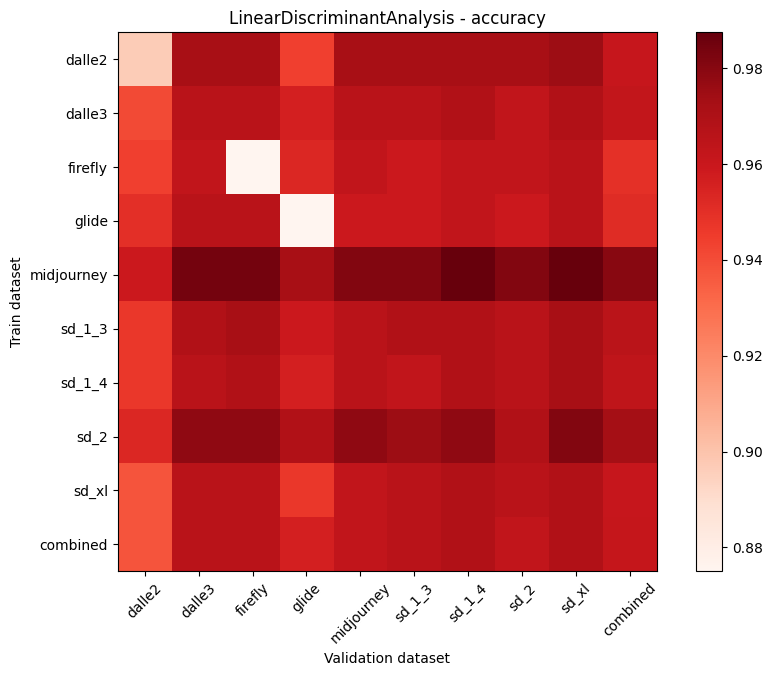

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.896875,0.971875,0.971875,0.943750,0.971875,0.971875,0.971875,0.971875,0.975000,0.960764
dalle3,0.940625,0.965625,0.965625,0.956250,0.965625,0.965625,0.968750,0.962500,0.968750,0.962153
firefly,0.943750,0.962500,0.875000,0.953125,0.962500,0.959375,0.962500,0.962500,0.965625,0.949653
glide,0.950000,0.965625,0.965625,0.875000,0.959375,0.959375,0.962500,0.959375,0.965625,0.951389
midjourney,0.959375,0.984375,0.984375,0.971875,0.981250,0.981250,0.987500,0.981250,0.987500,0.979861
sd_1_3,0.946875,0.968750,0.971875,0.959375,0.965625,0.968750,0.968750,0.965625,0.971875,0.965278
sd_1_4,0.946875,0.965625,0.968750,0.956250,0.965625,0.962500,0.968750,0.965625,0.971875,0.963542
sd_2,0.953125,0.978125,0.978125,0.968750,0.978125,0.975000,0.978125,0.968750,0.981250,0.973264
sd_xl,0.937500,0.965625,0.965625,0.946875,0.962500,0.965625,0.968750,0.965625,0.968750,0.960764


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.896875,0.971875,0.971875,0.943750,0.971875,0.971875,0.971875,0.971875,0.975000,0.960764
dalle3,0.940625,0.965625,0.965625,0.956250,0.965625,0.965625,0.968750,0.962500,0.968750,0.962153
firefly,0.943750,0.962500,0.875000,0.953125,0.962500,0.959375,0.962500,0.962500,0.965625,0.949653
glide,0.950000,0.965625,0.965625,0.875000,0.959375,0.959375,0.962500,0.959375,0.965625,0.951389
midjourney,0.959375,0.984375,0.984375,0.971875,0.981250,0.981250,0.987500,0.981250,0.987500,0.979861
sd_1_3,0.946875,0.968750,0.971875,0.959375,0.965625,0.968750,0.968750,0.965625,0.971875,0.965278
sd_1_4,0.946875,0.965625,0.968750,0.956250,0.965625,0.962500,0.968750,0.965625,0.971875,0.963542
sd_2,0.953125,0.978125,0.978125,0.968750,0.978125,0.975000,0.978125,0.968750,0.981250,0.973264
sd_xl,0.937500,0.965625,0.965625,0.946875,0.962500,0.965625,0.968750,0.965625,0.968750,0.960764


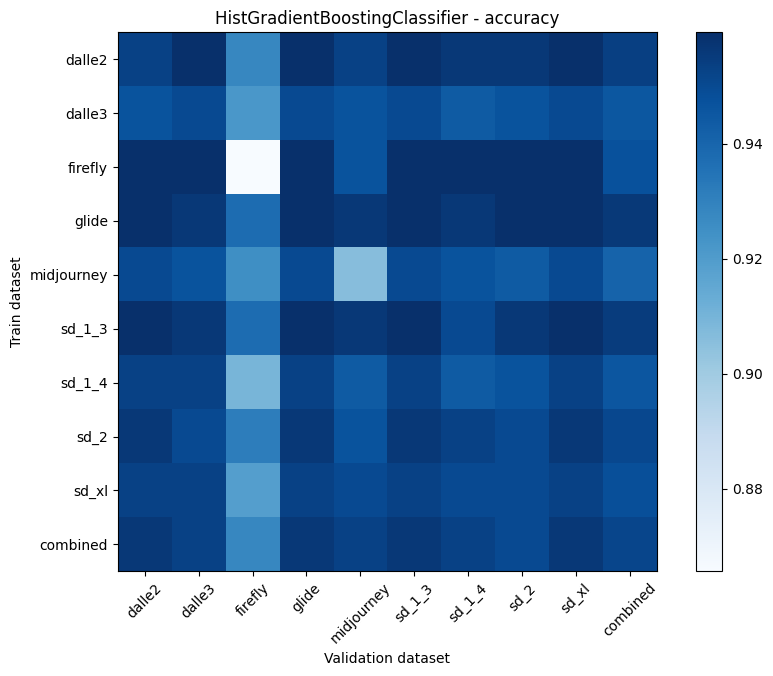

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.953125,0.959375,0.928125,0.959375,0.953125,0.959375,0.956250,0.956250,0.959375,0.953819
dalle3,0.946875,0.950000,0.921875,0.950000,0.946875,0.950000,0.943750,0.946875,0.950000,0.945139
firefly,0.959375,0.959375,0.865625,0.959375,0.946875,0.959375,0.959375,0.959375,0.959375,0.947569
glide,0.959375,0.956250,0.937500,0.959375,0.956250,0.959375,0.956250,0.959375,0.959375,0.955903
midjourney,0.950000,0.946875,0.925000,0.950000,0.906250,0.950000,0.946875,0.943750,0.950000,0.940972
sd_1_3,0.959375,0.956250,0.937500,0.959375,0.956250,0.959375,0.950000,0.956250,0.959375,0.954861
sd_1_4,0.953125,0.953125,0.909375,0.953125,0.943750,0.953125,0.943750,0.946875,0.953125,0.945486
sd_2,0.956250,0.950000,0.931250,0.956250,0.946875,0.956250,0.953125,0.950000,0.956250,0.950694
sd_xl,0.953125,0.953125,0.918750,0.953125,0.950000,0.953125,0.950000,0.950000,0.953125,0.948264


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.953125,0.959375,0.928125,0.959375,0.953125,0.959375,0.956250,0.956250,0.959375,0.953819
dalle3,0.946875,0.950000,0.921875,0.950000,0.946875,0.950000,0.943750,0.946875,0.950000,0.945139
firefly,0.959375,0.959375,0.865625,0.959375,0.946875,0.959375,0.959375,0.959375,0.959375,0.947569
glide,0.959375,0.956250,0.937500,0.959375,0.956250,0.959375,0.956250,0.959375,0.959375,0.955903
midjourney,0.950000,0.946875,0.925000,0.950000,0.906250,0.950000,0.946875,0.943750,0.950000,0.940972
sd_1_3,0.959375,0.956250,0.937500,0.959375,0.956250,0.959375,0.950000,0.956250,0.959375,0.954861
sd_1_4,0.953125,0.953125,0.909375,0.953125,0.943750,0.953125,0.943750,0.946875,0.953125,0.945486
sd_2,0.956250,0.950000,0.931250,0.956250,0.946875,0.956250,0.953125,0.950000,0.956250,0.950694
sd_xl,0.953125,0.953125,0.918750,0.953125,0.950000,0.953125,0.950000,0.950000,0.953125,0.948264


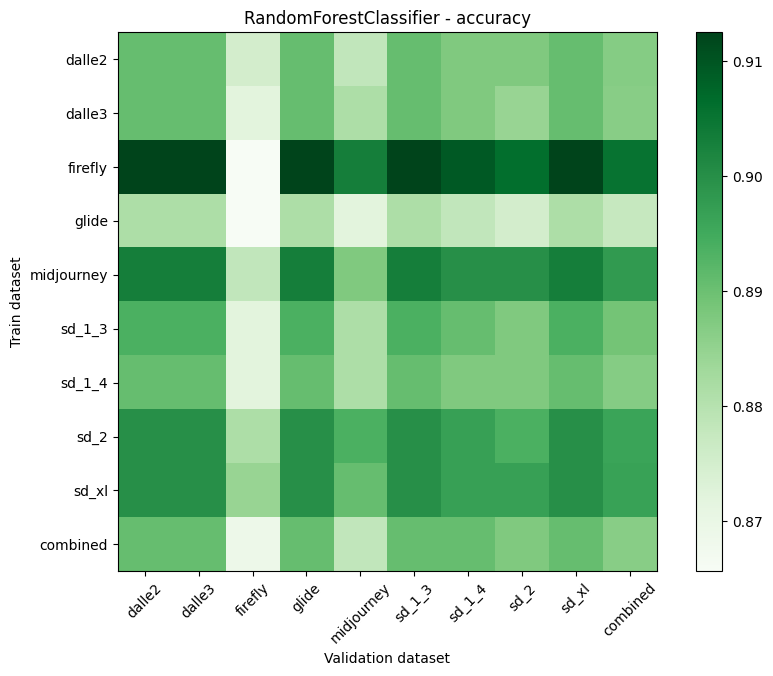

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.890625,0.890625,0.875000,0.890625,0.878125,0.890625,0.887500,0.887500,0.890625,0.886806
dalle3,0.890625,0.890625,0.871875,0.890625,0.881250,0.890625,0.887500,0.884375,0.890625,0.886458
firefly,0.912500,0.912500,0.865625,0.912500,0.903125,0.912500,0.909375,0.906250,0.912500,0.905208
glide,0.881250,0.881250,0.865625,0.881250,0.871875,0.881250,0.878125,0.875000,0.881250,0.877431
midjourney,0.903125,0.903125,0.878125,0.903125,0.887500,0.903125,0.900000,0.900000,0.903125,0.897917
sd_1_3,0.893750,0.893750,0.871875,0.893750,0.881250,0.893750,0.890625,0.887500,0.893750,0.888889
sd_1_4,0.890625,0.890625,0.871875,0.890625,0.881250,0.890625,0.887500,0.887500,0.890625,0.886806
sd_2,0.900000,0.900000,0.881250,0.900000,0.893750,0.900000,0.896875,0.893750,0.900000,0.896181
sd_xl,0.900000,0.900000,0.884375,0.900000,0.890625,0.900000,0.896875,0.896875,0.900000,0.896528


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.890625,0.890625,0.875000,0.890625,0.878125,0.890625,0.887500,0.887500,0.890625,0.886806
dalle3,0.890625,0.890625,0.871875,0.890625,0.881250,0.890625,0.887500,0.884375,0.890625,0.886458
firefly,0.912500,0.912500,0.865625,0.912500,0.903125,0.912500,0.909375,0.906250,0.912500,0.905208
glide,0.881250,0.881250,0.865625,0.881250,0.871875,0.881250,0.878125,0.875000,0.881250,0.877431
midjourney,0.903125,0.903125,0.878125,0.903125,0.887500,0.903125,0.900000,0.900000,0.903125,0.897917
sd_1_3,0.893750,0.893750,0.871875,0.893750,0.881250,0.893750,0.890625,0.887500,0.893750,0.888889
sd_1_4,0.890625,0.890625,0.871875,0.890625,0.881250,0.890625,0.887500,0.887500,0.890625,0.886806
sd_2,0.900000,0.900000,0.881250,0.900000,0.893750,0.900000,0.896875,0.893750,0.900000,0.896181
sd_xl,0.900000,0.900000,0.884375,0.900000,0.890625,0.900000,0.896875,0.896875,0.900000,0.896528


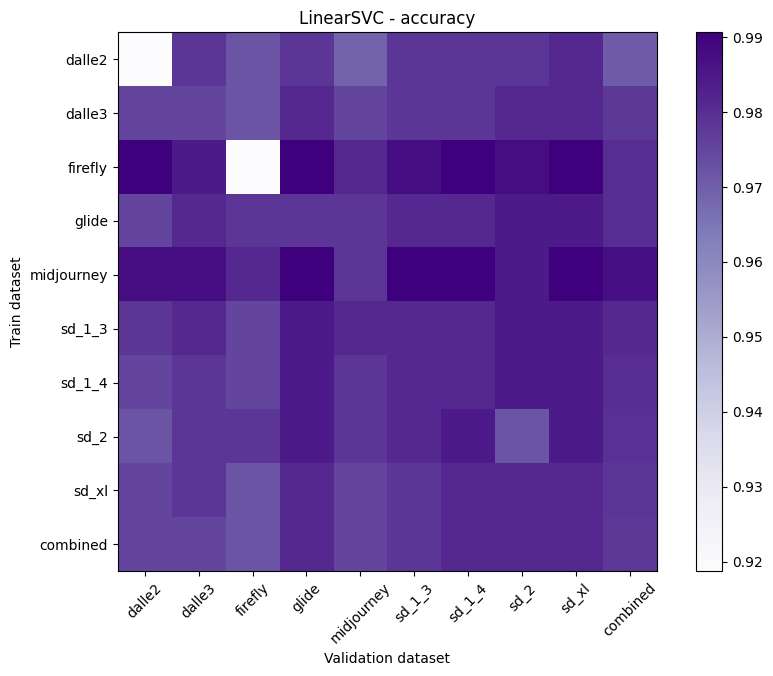

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.918750,0.978125,0.971875,0.978125,0.968750,0.978125,0.978125,0.978125,0.981250,0.970139
dalle3,0.975000,0.975000,0.971875,0.981250,0.975000,0.978125,0.978125,0.981250,0.981250,0.977431
firefly,0.990625,0.984375,0.918750,0.990625,0.981250,0.987500,0.990625,0.987500,0.990625,0.980208
glide,0.975000,0.981250,0.978125,0.978125,0.978125,0.981250,0.981250,0.984375,0.984375,0.980208
midjourney,0.987500,0.987500,0.981250,0.990625,0.978125,0.990625,0.990625,0.984375,0.990625,0.986806
sd_1_3,0.978125,0.981250,0.975000,0.984375,0.981250,0.981250,0.981250,0.984375,0.984375,0.981250
sd_1_4,0.975000,0.978125,0.975000,0.984375,0.978125,0.981250,0.981250,0.984375,0.984375,0.980208
sd_2,0.971875,0.978125,0.978125,0.984375,0.978125,0.981250,0.984375,0.971875,0.984375,0.979167
sd_xl,0.975000,0.978125,0.971875,0.981250,0.975000,0.978125,0.981250,0.981250,0.981250,0.978125


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.918750,0.978125,0.971875,0.978125,0.968750,0.978125,0.978125,0.978125,0.981250,0.970139
dalle3,0.975000,0.975000,0.971875,0.981250,0.975000,0.978125,0.978125,0.981250,0.981250,0.977431
firefly,0.990625,0.984375,0.918750,0.990625,0.981250,0.987500,0.990625,0.987500,0.990625,0.980208
glide,0.975000,0.981250,0.978125,0.978125,0.978125,0.981250,0.981250,0.984375,0.984375,0.980208
midjourney,0.987500,0.987500,0.981250,0.990625,0.978125,0.990625,0.990625,0.984375,0.990625,0.986806
sd_1_3,0.978125,0.981250,0.975000,0.984375,0.981250,0.981250,0.981250,0.984375,0.984375,0.981250
sd_1_4,0.975000,0.978125,0.975000,0.984375,0.978125,0.981250,0.981250,0.984375,0.984375,0.980208
sd_2,0.971875,0.978125,0.978125,0.984375,0.978125,0.981250,0.984375,0.971875,0.984375,0.979167
sd_xl,0.975000,0.978125,0.971875,0.981250,0.975000,0.978125,0.981250,0.981250,0.981250,0.978125


In [15]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

metric = "accuracy"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

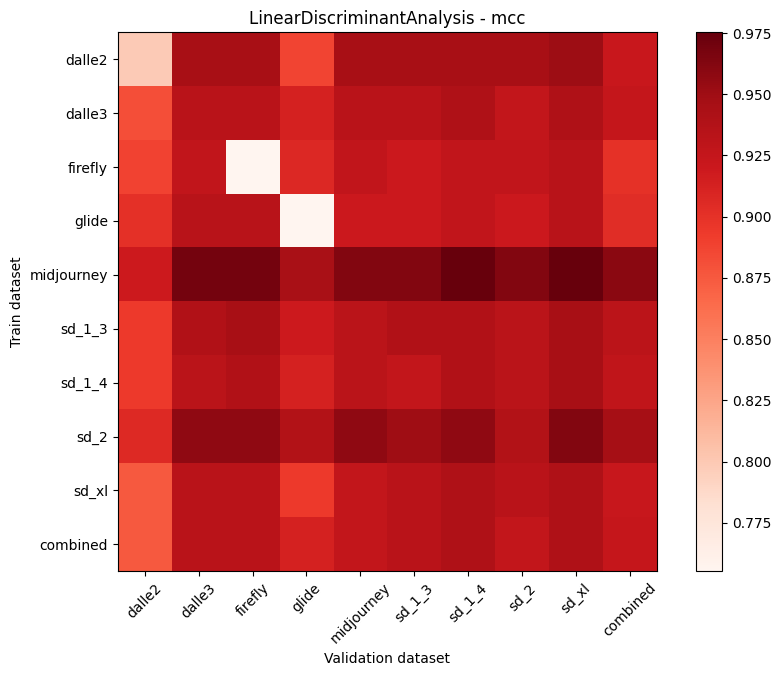

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.798593,0.944591,0.944591,0.887556,0.944591,0.944591,0.944591,0.944591,0.951128,0.921682
dalle3,0.881212,0.932634,0.932634,0.913051,0.932634,0.932634,0.939247,0.926064,0.939247,0.925337
firefly,0.887686,0.926703,0.755216,0.907011,0.926703,0.920096,0.926703,0.926703,0.933353,0.899811
glide,0.900529,0.933353,0.933353,0.755216,0.920096,0.920096,0.926703,0.920096,0.933353,0.903405
midjourney,0.919218,0.968899,0.968899,0.943755,0.962553,0.962553,0.975285,0.962553,0.975285,0.959746
sd_1_3,0.893718,0.938596,0.945171,0.919124,0.932064,0.938596,0.938596,0.932064,0.945171,0.931341
sd_1_4,0.893718,0.932064,0.938596,0.912714,0.932064,0.925573,0.938596,0.932064,0.945171,0.927732
sd_2,0.906409,0.956677,0.956677,0.937537,0.956677,0.950256,0.956677,0.937537,0.963139,0.946707
sd_xl,0.874956,0.932634,0.932634,0.893833,0.926064,0.932634,0.939247,0.932634,0.939247,0.922433


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.798593,0.944591,0.944591,0.887556,0.944591,0.944591,0.944591,0.944591,0.951128,0.922758
dalle3,0.881212,0.932634,0.932634,0.913051,0.932634,0.932634,0.939247,0.926064,0.939247,0.925484
firefly,0.887686,0.926703,0.755216,0.907011,0.926703,0.920096,0.926703,0.926703,0.933353,0.901130
glide,0.900529,0.933353,0.933353,0.755216,0.920096,0.920096,0.926703,0.920096,0.933353,0.904755
midjourney,0.919218,0.968899,0.968899,0.943755,0.962553,0.962553,0.975285,0.962553,0.975285,0.959889
sd_1_3,0.893718,0.938596,0.945171,0.919124,0.932064,0.938596,0.938596,0.932064,0.945171,0.931456
sd_1_4,0.893718,0.932064,0.938596,0.912714,0.932064,0.925573,0.938596,0.932064,0.945171,0.927840
sd_2,0.906409,0.956677,0.956677,0.937537,0.956677,0.950256,0.956677,0.937537,0.963139,0.946843
sd_xl,0.874956,0.932634,0.932634,0.893833,0.926064,0.932634,0.939247,0.932634,0.939247,0.922654


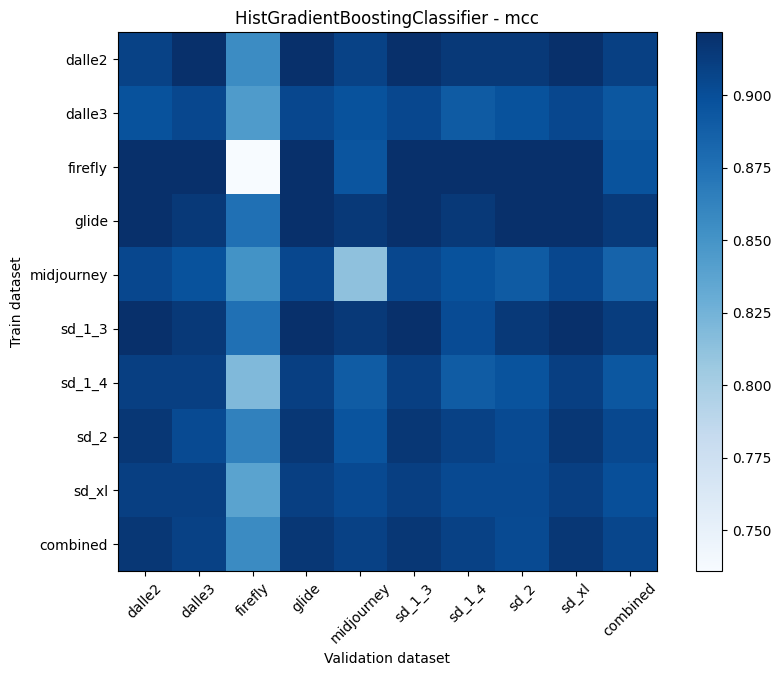

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.908252,0.921656,0.856300,0.921656,0.908252,0.921656,0.914932,0.914932,0.921656,0.909733
dalle3,0.897495,0.904330,0.844377,0.904330,0.897495,0.904330,0.890705,0.897495,0.904330,0.893717
firefly,0.921656,0.921656,0.735842,0.921656,0.895021,0.921656,0.921656,0.921656,0.921656,0.896483
glide,0.921656,0.914932,0.875485,0.921656,0.914932,0.921656,0.914932,0.921656,0.921656,0.914188
midjourney,0.904330,0.897495,0.850873,0.904330,0.812454,0.904330,0.897495,0.890705,0.904330,0.884708
sd_1_3,0.921656,0.914932,0.875485,0.921656,0.914932,0.921656,0.901616,0.914932,0.921656,0.911958
sd_1_4,0.910077,0.910077,0.818681,0.910077,0.889817,0.910077,0.889817,0.896526,0.910077,0.893539
sd_2,0.915852,0.902374,0.862963,0.915852,0.895702,0.915852,0.909091,0.902374,0.915852,0.903863
sd_xl,0.910077,0.910077,0.837629,0.910077,0.903279,0.910077,0.903279,0.903279,0.910077,0.899522


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.908252,0.921656,0.856300,0.921656,0.908252,0.921656,0.914932,0.914932,0.921656,0.909921
dalle3,0.897495,0.904330,0.844377,0.904330,0.897495,0.904330,0.890705,0.897495,0.904330,0.893876
firefly,0.921656,0.921656,0.735842,0.921656,0.895021,0.921656,0.921656,0.921656,0.921656,0.898051
glide,0.921656,0.914932,0.875485,0.921656,0.914932,0.921656,0.914932,0.921656,0.921656,0.914285
midjourney,0.904330,0.897495,0.850873,0.904330,0.812454,0.904330,0.897495,0.890705,0.904330,0.885149
sd_1_3,0.921656,0.914932,0.875485,0.921656,0.914932,0.921656,0.901616,0.914932,0.921656,0.912058
sd_1_4,0.910077,0.910077,0.818681,0.910077,0.889817,0.910077,0.889817,0.896526,0.910077,0.893914
sd_2,0.915852,0.902374,0.862963,0.915852,0.895702,0.915852,0.909091,0.902374,0.915852,0.903990
sd_xl,0.910077,0.910077,0.837629,0.910077,0.903279,0.910077,0.903279,0.903279,0.910077,0.899761


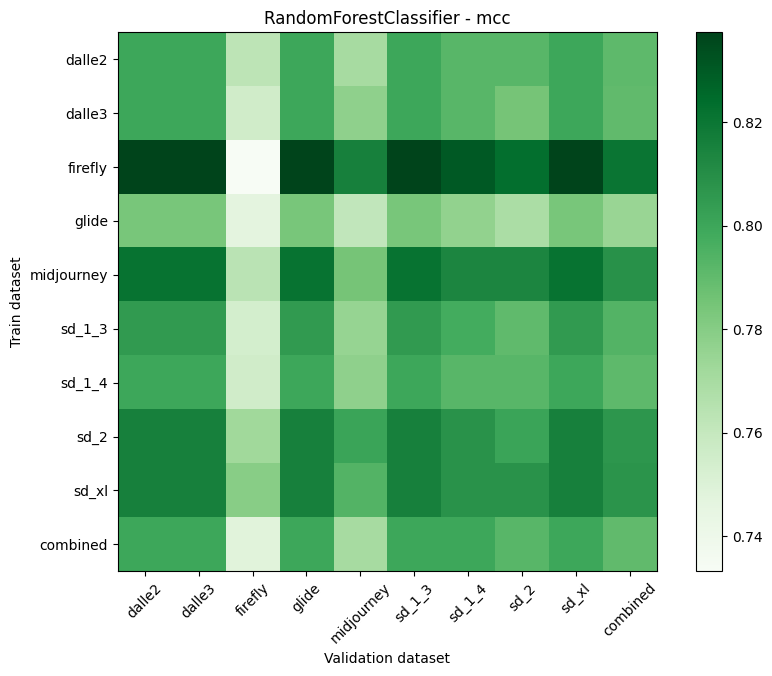

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.799818,0.799818,0.762662,0.799818,0.769983,0.799818,0.792275,0.792275,0.799818,0.790606
dalle3,0.799818,0.799818,0.755392,0.799818,0.777359,0.799818,0.792275,0.784789,0.799818,0.789773
firefly,0.837379,0.837379,0.733178,0.837379,0.815697,0.837379,0.830100,0.822873,0.837379,0.820476
glide,0.784006,0.784006,0.746295,0.784006,0.761207,0.784006,0.776347,0.768748,0.784006,0.774653
midjourney,0.821161,0.821161,0.763483,0.821161,0.784735,0.821161,0.813769,0.813769,0.821161,0.808872
sd_1_3,0.805125,0.805125,0.753732,0.805125,0.775439,0.805125,0.797620,0.790171,0.805125,0.793475
sd_1_4,0.799818,0.799818,0.755392,0.799818,0.777359,0.799818,0.792275,0.792275,0.799818,0.790606
sd_2,0.815796,0.815796,0.772022,0.815796,0.800992,0.815796,0.808367,0.800992,0.815796,0.806723
sd_xl,0.815796,0.815796,0.779188,0.815796,0.793672,0.815796,0.808367,0.808367,0.815796,0.807545


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.799818,0.799818,0.762662,0.799818,0.769983,0.799818,0.792275,0.792275,0.799818,0.790698
dalle3,0.799818,0.799818,0.755392,0.799818,0.777359,0.799818,0.792275,0.784789,0.799818,0.789878
firefly,0.837379,0.837379,0.733178,0.837379,0.815697,0.837379,0.830100,0.822873,0.837379,0.820972
glide,0.784006,0.784006,0.746295,0.784006,0.761207,0.784006,0.776347,0.768748,0.784006,0.774736
midjourney,0.821161,0.821161,0.763483,0.821161,0.784735,0.821161,0.813769,0.813769,0.821161,0.809063
sd_1_3,0.805125,0.805125,0.753732,0.805125,0.775439,0.805125,0.797620,0.790171,0.805125,0.793621
sd_1_4,0.799818,0.799818,0.755392,0.799818,0.777359,0.799818,0.792275,0.792275,0.799818,0.790710
sd_2,0.815796,0.815796,0.772022,0.815796,0.800992,0.815796,0.808367,0.800992,0.815796,0.806817
sd_xl,0.815796,0.815796,0.779188,0.815796,0.793672,0.815796,0.808367,0.808367,0.815796,0.807619


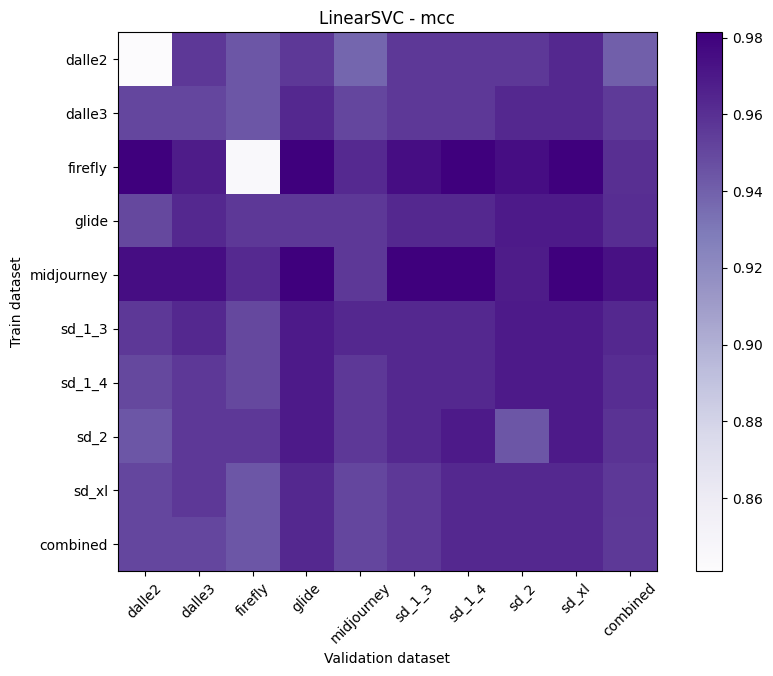

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.840926,0.956677,0.943877,0.956677,0.937537,0.956677,0.956677,0.956677,0.963139,0.940350
dalle3,0.950256,0.950256,0.943877,0.963139,0.950256,0.956677,0.956677,0.963139,0.963139,0.955247
firefly,0.981410,0.968754,0.844420,0.981410,0.962487,0.975062,0.981410,0.975062,0.981410,0.960406
glide,0.950045,0.962771,0.956388,0.956388,0.956388,0.962771,0.962771,0.969195,0.969195,0.960638
midjourney,0.975062,0.975062,0.962487,0.981410,0.956258,0.981410,0.981410,0.968754,0.981410,0.973656
sd_1_3,0.956388,0.962771,0.950045,0.969195,0.962771,0.962771,0.962771,0.969195,0.969195,0.962771
sd_1_4,0.950045,0.956388,0.950045,0.969195,0.956388,0.962771,0.962771,0.969195,0.969195,0.960638
sd_2,0.943742,0.956388,0.956388,0.969195,0.956388,0.962771,0.969195,0.943742,0.969195,0.958511
sd_xl,0.950256,0.956677,0.943877,0.963139,0.950256,0.956677,0.963139,0.963139,0.963139,0.956677


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.840926,0.956677,0.943877,0.956677,0.937537,0.956677,0.956677,0.956677,0.963139,0.940985
dalle3,0.950256,0.950256,0.943877,0.963139,0.950256,0.956677,0.956677,0.963139,0.963139,0.955269
firefly,0.981410,0.968754,0.844420,0.981410,0.962487,0.975062,0.981410,0.975062,0.981410,0.961269
glide,0.950045,0.962771,0.956388,0.956388,0.956388,0.962771,0.962771,0.969195,0.969195,0.960657
midjourney,0.975062,0.975062,0.962487,0.981410,0.956258,0.981410,0.981410,0.968754,0.981410,0.973696
sd_1_3,0.956388,0.962771,0.950045,0.969195,0.962771,0.962771,0.962771,0.969195,0.969195,0.962789
sd_1_4,0.950045,0.956388,0.950045,0.969195,0.956388,0.962771,0.962771,0.969195,0.969195,0.960666
sd_2,0.943742,0.956388,0.956388,0.969195,0.956388,0.962771,0.969195,0.943742,0.969195,0.958556
sd_xl,0.950256,0.956677,0.943877,0.963139,0.950256,0.956677,0.963139,0.963139,0.963139,0.956700


In [16]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

### Test data

In [17]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nValidation set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print() 
            # leave only the columns that are in the training set
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9325
F1: 0.9322
Precision: 0.9394
Recall: 0.9325
MCC: 0.8718

Model: LinearDiscriminantAnalysis
Accuracy: 0.9175
F1: 0.9174
Precision: 0.9193
Recall: 0.9175
MCC: 0.8368

Model: RandomForestClassifier
Accuracy: 0.8625
F1: 0.8599
Precision: 0.8922
Recall: 0.8625
MCC: 0.7541

Model: LinearSVC
Accuracy: 0.9325
F1: 0.9324
Precision: 0.9338
Recall: 0.9325
MCC: 0.8663


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9350
F1: 0.9347
Precision: 0.9425
Recall: 0.9350
MCC: 0.8774

Model: LinearDiscriminantAnalysis
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9762
Recall: 0.9750
MCC: 0.9512

Model: RandomForestClassifier
Accuracy: 0.8625
F1: 0.8599
Precision: 0.8922
Recall: 0.8625
MCC: 0.7541

Model: LinearSVC
Accuracy: 0.9800
F1: 0.9800
Precision: 0.9808
Recall: 0.9800
MCC: 0.9608


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

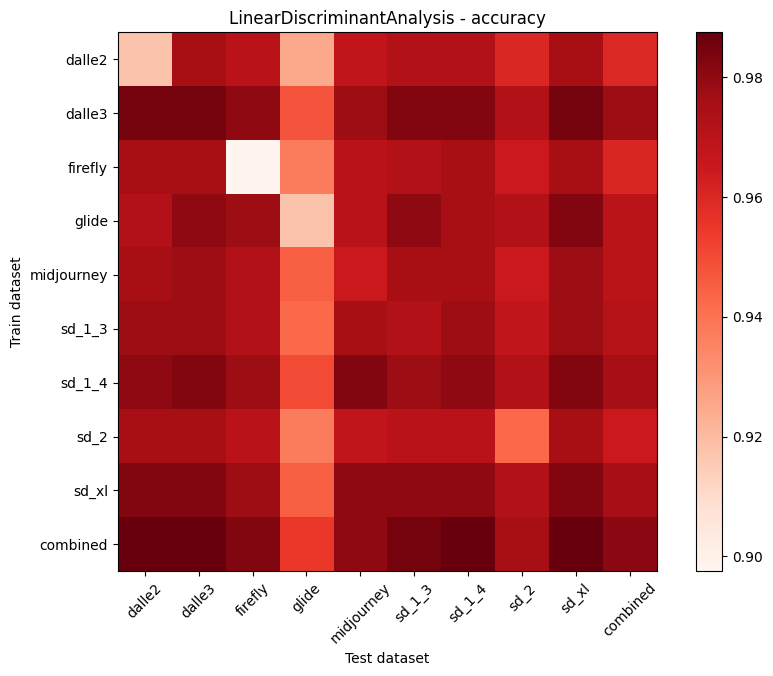

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9175,0.9750,0.9700,0.9250,0.9675,0.9725,0.9725,0.9600,0.9750,0.959444
dalle3,0.9850,0.9850,0.9800,0.9475,0.9775,0.9825,0.9825,0.9725,0.9850,0.977500
firefly,0.9750,0.9750,0.8975,0.9375,0.9700,0.9725,0.9750,0.9650,0.9750,0.960278
glide,0.9725,0.9800,0.9775,0.9175,0.9700,0.9800,0.9750,0.9725,0.9825,0.969722
midjourney,0.9750,0.9775,0.9725,0.9450,0.9650,0.9750,0.9750,0.9650,0.9775,0.969722
sd_1_3,0.9775,0.9775,0.9725,0.9425,0.9750,0.9725,0.9775,0.9675,0.9775,0.971111
sd_1_4,0.9800,0.9825,0.9775,0.9500,0.9825,0.9775,0.9800,0.9725,0.9825,0.976111
sd_2,0.9750,0.9750,0.9700,0.9375,0.9675,0.9700,0.9700,0.9425,0.9750,0.964722
sd_xl,0.9825,0.9825,0.9775,0.9450,0.9800,0.9800,0.9800,0.9725,0.9825,0.975833


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9175,0.9750,0.9700,0.9250,0.9675,0.9725,0.9725,0.9600,0.9750,0.959444
dalle3,0.9850,0.9850,0.9800,0.9475,0.9775,0.9825,0.9825,0.9725,0.9850,0.977500
firefly,0.9750,0.9750,0.8975,0.9375,0.9700,0.9725,0.9750,0.9650,0.9750,0.960278
glide,0.9725,0.9800,0.9775,0.9175,0.9700,0.9800,0.9750,0.9725,0.9825,0.969722
midjourney,0.9750,0.9775,0.9725,0.9450,0.9650,0.9750,0.9750,0.9650,0.9775,0.969722
sd_1_3,0.9775,0.9775,0.9725,0.9425,0.9750,0.9725,0.9775,0.9675,0.9775,0.971111
sd_1_4,0.9800,0.9825,0.9775,0.9500,0.9825,0.9775,0.9800,0.9725,0.9825,0.976111
sd_2,0.9750,0.9750,0.9700,0.9375,0.9675,0.9700,0.9700,0.9425,0.9750,0.964722
sd_xl,0.9825,0.9825,0.9775,0.9450,0.9800,0.9800,0.9800,0.9725,0.9825,0.975833


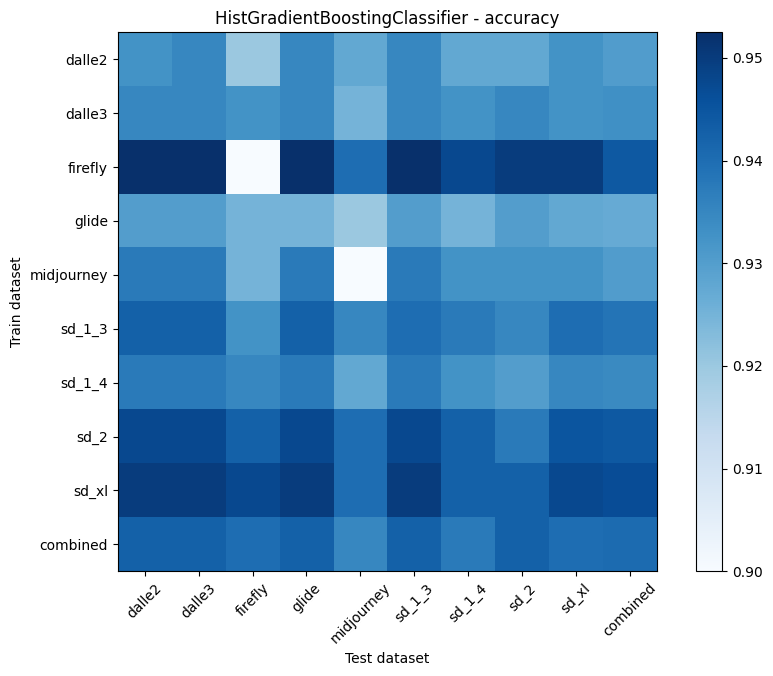

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9325,0.9350,0.9200,0.9350,0.9275,0.9350,0.9275,0.9275,0.9325,0.930278
dalle3,0.9350,0.9350,0.9325,0.9350,0.9250,0.9350,0.9325,0.9350,0.9325,0.933056
firefly,0.9525,0.9525,0.9000,0.9525,0.9400,0.9525,0.9475,0.9500,0.9500,0.944167
glide,0.9300,0.9300,0.9250,0.9250,0.9200,0.9300,0.9250,0.9300,0.9275,0.926944
midjourney,0.9375,0.9375,0.9250,0.9375,0.9000,0.9375,0.9325,0.9325,0.9325,0.930278
sd_1_3,0.9425,0.9425,0.9325,0.9425,0.9350,0.9400,0.9375,0.9350,0.9400,0.938611
sd_1_4,0.9375,0.9375,0.9350,0.9375,0.9275,0.9375,0.9325,0.9300,0.9350,0.934444
sd_2,0.9475,0.9475,0.9425,0.9475,0.9400,0.9475,0.9425,0.9375,0.9450,0.944167
sd_xl,0.9500,0.9500,0.9475,0.9500,0.9400,0.9500,0.9425,0.9425,0.9475,0.946667


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9325,0.9350,0.9200,0.9350,0.9275,0.9350,0.9275,0.9275,0.9325,0.930278
dalle3,0.9350,0.9350,0.9325,0.9350,0.9250,0.9350,0.9325,0.9350,0.9325,0.933056
firefly,0.9525,0.9525,0.9000,0.9525,0.9400,0.9525,0.9475,0.9500,0.9500,0.944167
glide,0.9300,0.9300,0.9250,0.9250,0.9200,0.9300,0.9250,0.9300,0.9275,0.926944
midjourney,0.9375,0.9375,0.9250,0.9375,0.9000,0.9375,0.9325,0.9325,0.9325,0.930278
sd_1_3,0.9425,0.9425,0.9325,0.9425,0.9350,0.9400,0.9375,0.9350,0.9400,0.938611
sd_1_4,0.9375,0.9375,0.9350,0.9375,0.9275,0.9375,0.9325,0.9300,0.9350,0.934444
sd_2,0.9475,0.9475,0.9425,0.9475,0.9400,0.9475,0.9425,0.9375,0.9450,0.944167
sd_xl,0.9500,0.9500,0.9475,0.9500,0.9400,0.9500,0.9425,0.9425,0.9475,0.946667


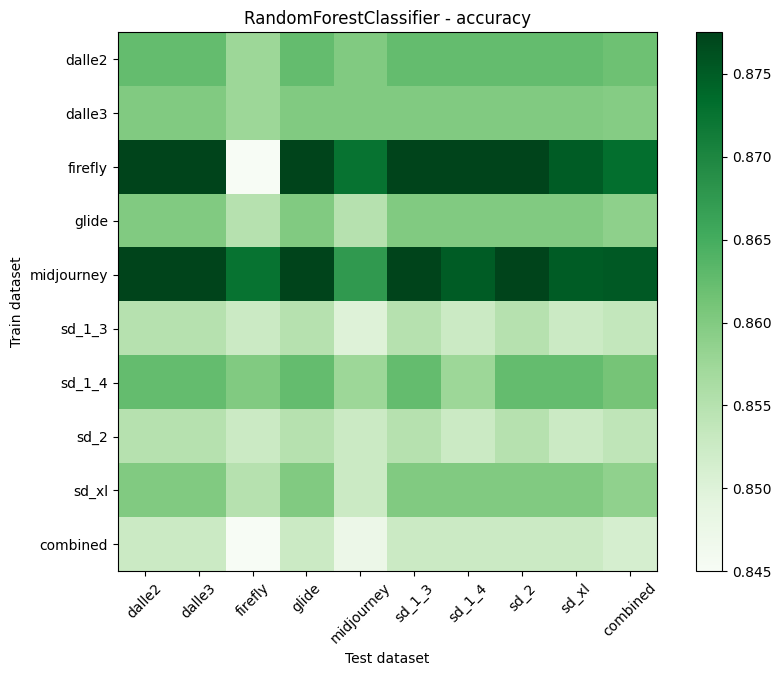

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.8625,0.8625,0.8575,0.8625,0.8600,0.8625,0.8625,0.8625,0.8625,0.861667
dalle3,0.8600,0.8600,0.8575,0.8600,0.8600,0.8600,0.8600,0.8600,0.8600,0.859722
firefly,0.8775,0.8775,0.8450,0.8775,0.8725,0.8775,0.8775,0.8775,0.8750,0.873056
glide,0.8600,0.8600,0.8550,0.8600,0.8550,0.8600,0.8600,0.8600,0.8600,0.858889
midjourney,0.8775,0.8775,0.8725,0.8775,0.8675,0.8775,0.8750,0.8775,0.8750,0.875278
sd_1_3,0.8550,0.8550,0.8525,0.8550,0.8500,0.8550,0.8525,0.8550,0.8525,0.853611
sd_1_4,0.8625,0.8625,0.8600,0.8625,0.8575,0.8625,0.8575,0.8625,0.8625,0.861111
sd_2,0.8550,0.8550,0.8525,0.8550,0.8525,0.8550,0.8525,0.8550,0.8525,0.853889
sd_xl,0.8600,0.8600,0.8550,0.8600,0.8525,0.8600,0.8600,0.8600,0.8600,0.858611


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.8625,0.8625,0.8575,0.8625,0.8600,0.8625,0.8625,0.8625,0.8625,0.861667
dalle3,0.8600,0.8600,0.8575,0.8600,0.8600,0.8600,0.8600,0.8600,0.8600,0.859722
firefly,0.8775,0.8775,0.8450,0.8775,0.8725,0.8775,0.8775,0.8775,0.8750,0.873056
glide,0.8600,0.8600,0.8550,0.8600,0.8550,0.8600,0.8600,0.8600,0.8600,0.858889
midjourney,0.8775,0.8775,0.8725,0.8775,0.8675,0.8775,0.8750,0.8775,0.8750,0.875278
sd_1_3,0.8550,0.8550,0.8525,0.8550,0.8500,0.8550,0.8525,0.8550,0.8525,0.853611
sd_1_4,0.8625,0.8625,0.8600,0.8625,0.8575,0.8625,0.8575,0.8625,0.8625,0.861111
sd_2,0.8550,0.8550,0.8525,0.8550,0.8525,0.8550,0.8525,0.8550,0.8525,0.853889
sd_xl,0.8600,0.8600,0.8550,0.8600,0.8525,0.8600,0.8600,0.8600,0.8600,0.858611


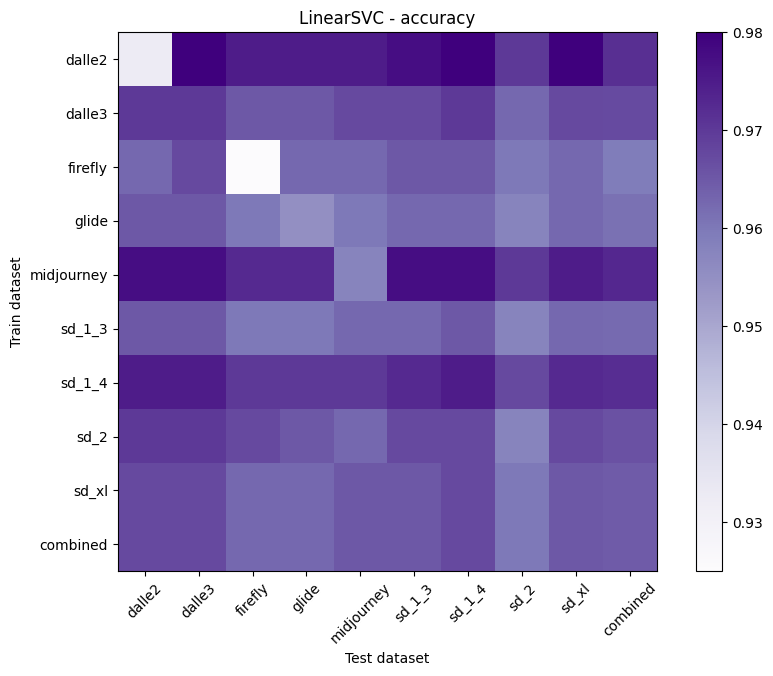

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9325,0.9800,0.9750,0.9750,0.9750,0.9775,0.9800,0.9700,0.9800,0.971667
dalle3,0.9700,0.9700,0.9650,0.9650,0.9675,0.9675,0.9700,0.9625,0.9675,0.967222
firefly,0.9625,0.9675,0.9250,0.9625,0.9625,0.9650,0.9650,0.9600,0.9625,0.959167
glide,0.9650,0.9650,0.9600,0.9550,0.9600,0.9625,0.9625,0.9575,0.9625,0.961111
midjourney,0.9775,0.9775,0.9725,0.9725,0.9575,0.9775,0.9775,0.9700,0.9750,0.973056
sd_1_3,0.9650,0.9650,0.9600,0.9600,0.9625,0.9625,0.9650,0.9575,0.9625,0.962222
sd_1_4,0.9750,0.9750,0.9700,0.9700,0.9700,0.9725,0.9750,0.9675,0.9725,0.971944
sd_2,0.9700,0.9700,0.9675,0.9650,0.9625,0.9675,0.9675,0.9575,0.9675,0.966111
sd_xl,0.9675,0.9675,0.9625,0.9625,0.9650,0.9650,0.9675,0.9600,0.9650,0.964722


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9325,0.9800,0.9750,0.9750,0.9750,0.9775,0.9800,0.9700,0.9800,0.971667
dalle3,0.9700,0.9700,0.9650,0.9650,0.9675,0.9675,0.9700,0.9625,0.9675,0.967222
firefly,0.9625,0.9675,0.9250,0.9625,0.9625,0.9650,0.9650,0.9600,0.9625,0.959167
glide,0.9650,0.9650,0.9600,0.9550,0.9600,0.9625,0.9625,0.9575,0.9625,0.961111
midjourney,0.9775,0.9775,0.9725,0.9725,0.9575,0.9775,0.9775,0.9700,0.9750,0.973056
sd_1_3,0.9650,0.9650,0.9600,0.9600,0.9625,0.9625,0.9650,0.9575,0.9625,0.962222
sd_1_4,0.9750,0.9750,0.9700,0.9700,0.9700,0.9725,0.9750,0.9675,0.9725,0.971944
sd_2,0.9700,0.9700,0.9675,0.9650,0.9625,0.9675,0.9675,0.9575,0.9675,0.966111
sd_xl,0.9675,0.9675,0.9625,0.9625,0.9650,0.9650,0.9675,0.9600,0.9650,0.964722


In [18]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "accuracy"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

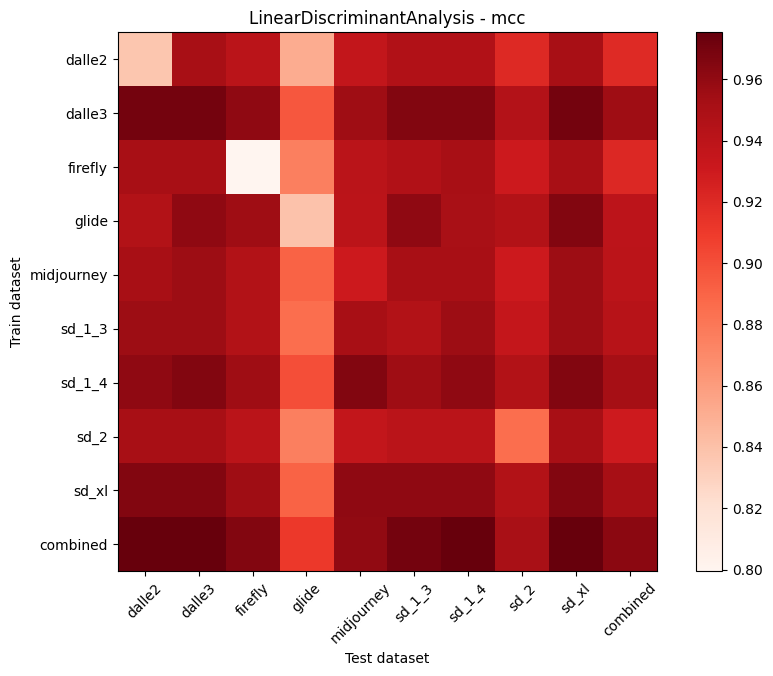

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.836770,0.951190,0.940753,0.851064,0.935573,0.945958,0.945958,0.920184,0.951190,0.919053
dalle3,0.970437,0.970437,0.960192,0.895908,0.955107,0.965302,0.965302,0.945012,0.970437,0.955107
firefly,0.951190,0.951190,0.799419,0.875274,0.940753,0.945958,0.951190,0.930419,0.951190,0.920750
glide,0.945106,0.960432,0.955299,0.838794,0.940047,0.960432,0.950190,0.945106,0.965592,0.939486
midjourney,0.950761,0.955968,0.945579,0.890178,0.930186,0.950761,0.950761,0.930186,0.955968,0.939852
sd_1_3,0.955968,0.955968,0.945579,0.885277,0.950761,0.945579,0.955968,0.935292,0.955968,0.942712
sd_1_4,0.960432,0.965592,0.955299,0.900405,0.965592,0.955299,0.960432,0.945106,0.965592,0.952457
sd_2,0.951190,0.951190,0.940753,0.875274,0.935573,0.940753,0.940753,0.885100,0.951190,0.929848
sd_xl,0.965592,0.965592,0.955299,0.890713,0.960432,0.960432,0.960432,0.945106,0.965592,0.951890


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.836770,0.951190,0.940753,0.851064,0.935573,0.945958,0.945958,0.920184,0.951190,0.919849
dalle3,0.970437,0.970437,0.960192,0.895908,0.955107,0.965302,0.965302,0.945012,0.970437,0.955348
firefly,0.951190,0.951190,0.799419,0.875274,0.940753,0.945958,0.951190,0.930419,0.951190,0.921842
glide,0.945106,0.960432,0.955299,0.838794,0.940047,0.960432,0.950190,0.945106,0.965592,0.940111
midjourney,0.950761,0.955968,0.945579,0.890178,0.930186,0.950761,0.950761,0.930186,0.955968,0.940039
sd_1_3,0.955968,0.955968,0.945579,0.885277,0.950761,0.945579,0.955968,0.935292,0.955968,0.942929
sd_1_4,0.960432,0.965592,0.955299,0.900405,0.965592,0.955299,0.960432,0.945106,0.965592,0.952639
sd_2,0.951190,0.951190,0.940753,0.875274,0.935573,0.940753,0.940753,0.885100,0.951190,0.930197
sd_xl,0.965592,0.965592,0.955299,0.890713,0.960432,0.960432,0.960432,0.945106,0.965592,0.952132


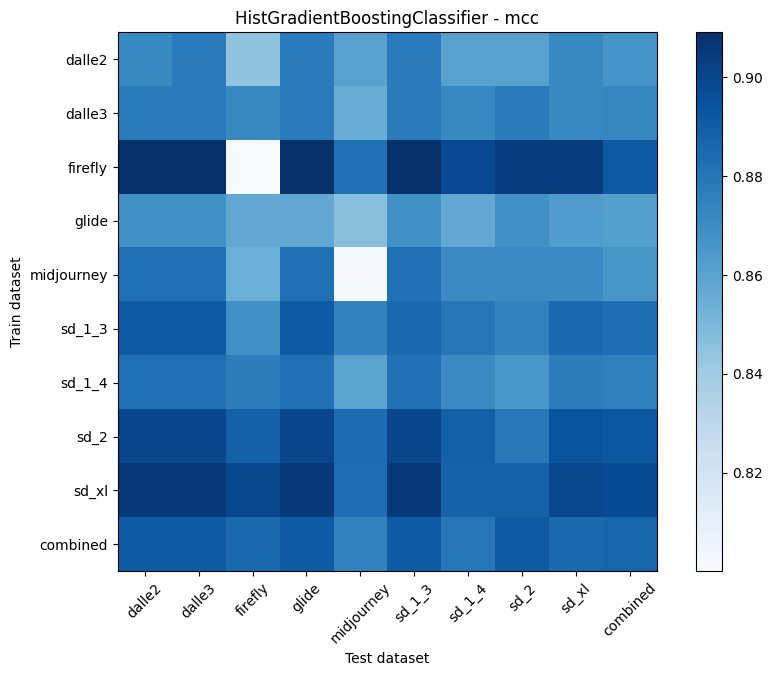

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.871838,0.877446,0.844232,0.877446,0.860710,0.877446,0.860710,0.860710,0.871838,0.866878
dalle3,0.877446,0.877446,0.871838,0.877446,0.855190,0.877446,0.871838,0.877446,0.871838,0.873082
firefly,0.909112,0.909112,0.800040,0.909112,0.882164,0.909112,0.898251,0.903667,0.903667,0.891071
glide,0.868554,0.868554,0.857275,0.857275,0.846114,0.868554,0.857275,0.868554,0.862899,0.861647
midjourney,0.881917,0.881917,0.854282,0.881917,0.801002,0.881917,0.870777,0.870777,0.870777,0.865863
sd_1_3,0.890911,0.890911,0.868930,0.890911,0.874383,0.885373,0.879864,0.874383,0.885373,0.882309
sd_1_4,0.881917,0.881917,0.876332,0.881917,0.859753,0.881917,0.870777,0.865251,0.876332,0.875095
sd_2,0.899975,0.899975,0.889021,0.899975,0.883586,0.899975,0.889021,0.878178,0.894484,0.892660
sd_xl,0.904534,0.904534,0.899066,0.904534,0.882830,0.904534,0.888214,0.888214,0.899066,0.897250


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.871838,0.877446,0.844232,0.877446,0.860710,0.877446,0.860710,0.860710,0.871838,0.866931
dalle3,0.877446,0.877446,0.871838,0.877446,0.855190,0.877446,0.871838,0.877446,0.871838,0.873104
firefly,0.909112,0.909112,0.800040,0.909112,0.882164,0.909112,0.898251,0.903667,0.903667,0.891582
glide,0.868554,0.868554,0.857275,0.857275,0.846114,0.868554,0.857275,0.868554,0.862899,0.861673
midjourney,0.881917,0.881917,0.854282,0.881917,0.801002,0.881917,0.870777,0.870777,0.870777,0.866143
sd_1_3,0.890911,0.890911,0.868930,0.890911,0.874383,0.885373,0.879864,0.874383,0.885373,0.882337
sd_1_4,0.881917,0.881917,0.876332,0.881917,0.859753,0.881917,0.870777,0.865251,0.876332,0.875124
sd_2,0.899975,0.899975,0.889021,0.899975,0.883586,0.899975,0.889021,0.878178,0.894484,0.892688
sd_xl,0.904534,0.904534,0.899066,0.904534,0.882830,0.904534,0.888214,0.888214,0.899066,0.897281


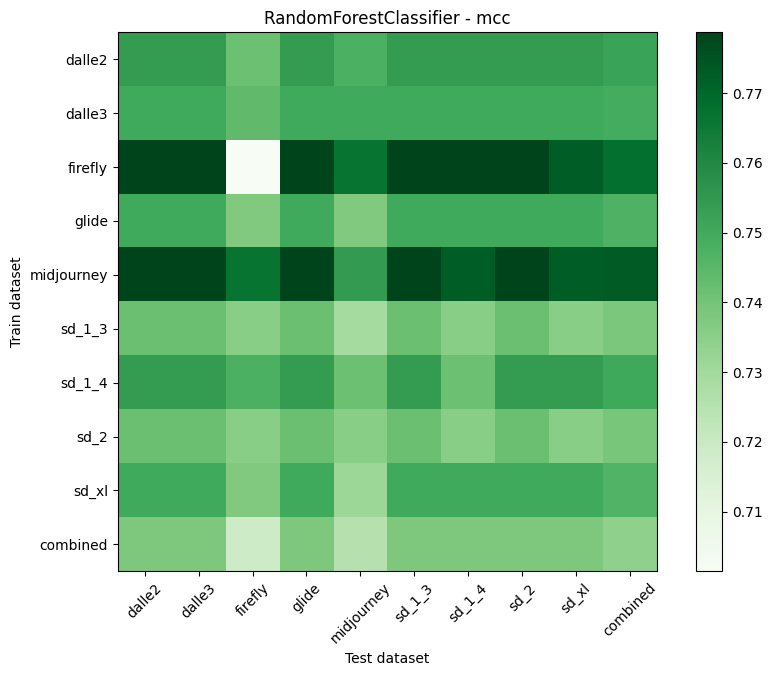

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.754074,0.754074,0.741510,0.754074,0.747772,0.754074,0.754074,0.754074,0.754074,0.751969
dalle3,0.750000,0.750000,0.743673,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.749295
firefly,0.778733,0.778733,0.701457,0.778733,0.766465,0.778733,0.778733,0.778733,0.772580,0.767820
glide,0.750000,0.750000,0.737386,0.750000,0.737386,0.750000,0.750000,0.750000,0.750000,0.747183
midjourney,0.778733,0.778733,0.766465,0.778733,0.754342,0.778733,0.772580,0.778733,0.772580,0.773262
sd_1_3,0.741881,0.741881,0.735503,0.741881,0.729167,0.741881,0.735503,0.741881,0.735503,0.738333
sd_1_4,0.754074,0.754074,0.747772,0.754074,0.741510,0.754074,0.741510,0.754074,0.754074,0.750568
sd_2,0.741881,0.741881,0.735503,0.741881,0.735503,0.741881,0.735503,0.741881,0.735503,0.739041
sd_xl,0.750000,0.750000,0.737386,0.750000,0.731139,0.750000,0.750000,0.750000,0.750000,0.746480


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.754074,0.754074,0.741510,0.754074,0.747772,0.754074,0.754074,0.754074,0.754074,0.751978
dalle3,0.750000,0.750000,0.743673,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.749297
firefly,0.778733,0.778733,0.701457,0.778733,0.766465,0.778733,0.778733,0.778733,0.772580,0.768100
glide,0.750000,0.750000,0.737386,0.750000,0.737386,0.750000,0.750000,0.750000,0.750000,0.747197
midjourney,0.778733,0.778733,0.766465,0.778733,0.754342,0.778733,0.772580,0.778733,0.772580,0.773293
sd_1_3,0.741881,0.741881,0.735503,0.741881,0.729167,0.741881,0.735503,0.741881,0.735503,0.738342
sd_1_4,0.754074,0.754074,0.747772,0.754074,0.741510,0.754074,0.741510,0.754074,0.754074,0.750582
sd_2,0.741881,0.741881,0.735503,0.741881,0.735503,0.741881,0.735503,0.741881,0.735503,0.739046
sd_xl,0.750000,0.750000,0.737386,0.750000,0.731139,0.750000,0.750000,0.750000,0.750000,0.746503


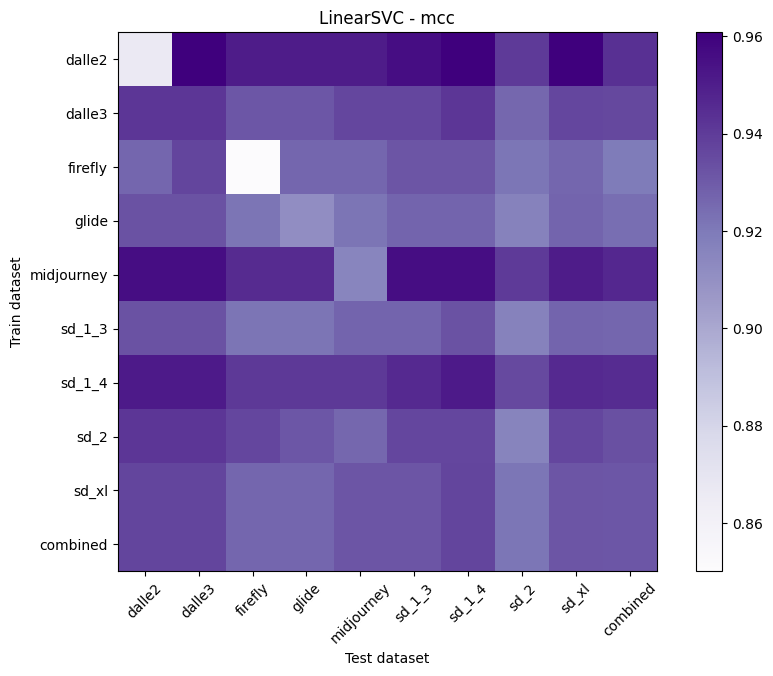

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.866311,0.960769,0.950428,0.950428,0.950428,0.955585,0.960769,0.940188,0.960769,0.943590
dalle3,0.941697,0.941697,0.931165,0.931165,0.936417,0.936417,0.941697,0.925938,0.936417,0.935832
firefly,0.926402,0.936981,0.850170,0.926402,0.926402,0.931679,0.931679,0.921152,0.926402,0.919408
glide,0.932287,0.932287,0.921660,0.911140,0.921660,0.926960,0.926960,0.916387,0.926960,0.924013
midjourney,0.955968,0.955968,0.945579,0.945579,0.915011,0.955968,0.955968,0.940423,0.950761,0.946729
sd_1_3,0.932287,0.932287,0.921660,0.921660,0.926960,0.926960,0.932287,0.916387,0.926960,0.926370
sd_1_4,0.951190,0.951190,0.940753,0.940753,0.940753,0.945958,0.951190,0.935573,0.945958,0.944799
sd_2,0.941697,0.941697,0.936417,0.931165,0.925938,0.936417,0.936417,0.915561,0.936417,0.933496
sd_xl,0.936981,0.936981,0.926402,0.926402,0.931679,0.931679,0.936981,0.921152,0.931679,0.931091


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.866311,0.960769,0.950428,0.950428,0.950428,0.955585,0.960769,0.940188,0.960769,0.943964
dalle3,0.941697,0.941697,0.931165,0.931165,0.936417,0.936417,0.941697,0.925938,0.936417,0.935845
firefly,0.926402,0.936981,0.850170,0.926402,0.926402,0.931679,0.931679,0.921152,0.926402,0.919697
glide,0.932287,0.932287,0.921660,0.911140,0.921660,0.926960,0.926960,0.916387,0.926960,0.924034
midjourney,0.955968,0.955968,0.945579,0.945579,0.915011,0.955968,0.955968,0.940423,0.950761,0.946803
sd_1_3,0.932287,0.932287,0.921660,0.921660,0.926960,0.926960,0.932287,0.916387,0.926960,0.926383
sd_1_4,0.951190,0.951190,0.940753,0.940753,0.940753,0.945958,0.951190,0.935573,0.945958,0.944813
sd_2,0.941697,0.941697,0.936417,0.931165,0.925938,0.936417,0.936417,0.915561,0.936417,0.933525
sd_xl,0.936981,0.936981,0.926402,0.926402,0.931679,0.931679,0.936981,0.921152,0.931679,0.931104


In [19]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

## Safe models and scalers

In [20]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/synthbuster/standardGeneralization/{dataset_name}"
        scalers_dir_path = f"scalers/synthbuster/standardGeneralization/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))